# Fig. S5: MEA Bayesian Information Criterion (BIC)

## imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle5
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparsePCA

In [2]:
file_path = 'ADD_YOUR_PATH_TO_DATA_HERE'

with open(file_path+'/MEA_dataset.pkl', 'rb') as handle:
    mea_dataset = pickle5.load(handle)

# --------------------------------------------------------------------------------------------------------------------

# normalized PSTHs

In [4]:
datatset_normalization = 'PSTHs_norm'

In [5]:
# number of cells per cluster
num_cells_cluster_i = len(mea_dataset[datatset_normalization][0])
num_cells_cluster_ii = len(mea_dataset[datatset_normalization][1])
num_cells_cluster_iii = len(mea_dataset[datatset_normalization][5])

In [8]:
cluster_i_traces_ctrl = np.zeros((num_cells_cluster_i,mea_dataset[datatset_normalization][0][0][0].shape[0]))
cluster_ii_traces_ctrl = np.zeros((num_cells_cluster_ii,mea_dataset[datatset_normalization][0][0][0].shape[0]))
cluster_iii_traces_ctrl = np.zeros((num_cells_cluster_iii,mea_dataset[datatset_normalization][0][0][0].shape[0]))

for i in range(num_cells_cluster_i):
    cluster_i_traces_ctrl[i,:] = mea_dataset[datatset_normalization][0][i][0]
for i in range(num_cells_cluster_ii):
    cluster_ii_traces_ctrl[i,:] = mea_dataset[datatset_normalization][1][i][0]
for i in range(num_cells_cluster_iii):
    cluster_iii_traces_ctrl[i,:] = mea_dataset[datatset_normalization][5][i][0]
    
# concatenate traces
ctrl_traces = np.vstack((cluster_i_traces_ctrl,cluster_ii_traces_ctrl,cluster_iii_traces_ctrl))

# --------------------------------------------------------------------------------------------------------------------

## sparse PCA

In [ ]:
sc = StandardScaler()
control_stand = sc.fit_transform(ctrl_traces)

In [16]:
random_state=42
n_components=20
spca = SparsePCA(n_components=n_components, alpha=3.5, random_state=random_state)
spca.fit(control_stand)
traces_transformed = spca.transform(control_stand)

In [25]:
zero_comp = np.where(np.mean(spca.components_,axis=1)==0)
spca_com = np.delete(spca.components_, zero_comp, 0)

# --------------------------------------------------------------------------------------------------------------------

## clustering

In [26]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    return -estimator.bic(X)

In [27]:
transformed_traces = np.delete(traces_transformed, zero_comp, 1)
features_stand = sc.fit_transform(transformed_traces)

In [22]:
param_grid = {"n_components": range(1, 11), "covariance_type": ["diag"]}
grid_search = GridSearchCV(GaussianMixture(max_iter=1000, n_init=1,random_state=1112), cv=5, param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(features_stand)

cluster_labels = grid_search.predict(features_stand)

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

n_cluster_lowest_bic = len(np.unique(cluster_labels))

# --------------------------------------------------------------------------------------------------------------------

## plot norm. BIC

In [23]:
# normalize BIC
bic = np.zeros(10)
for i in range(1,11):
    bic[i-1] = df[df['Number of components']==i]['BIC score'].min()
bic = bic/bic.min()

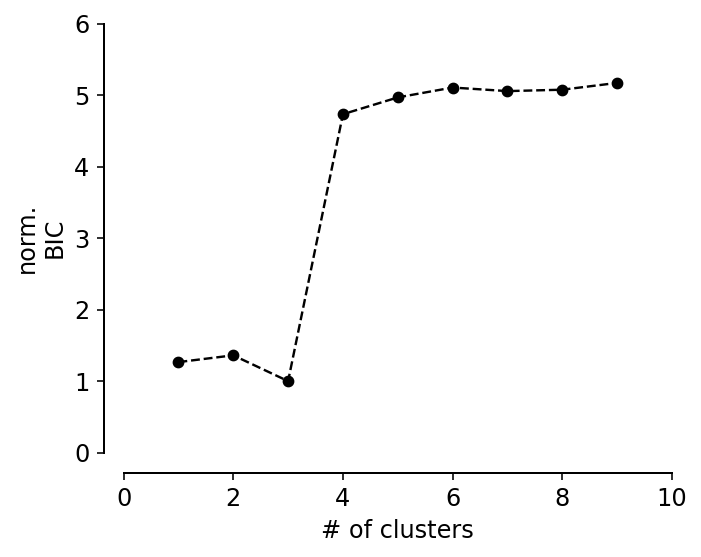

In [24]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(np.arange(1,10,1),bic[0:9],color='k',lw=2,marker='o',s=15)
ax.plot(np.arange(1,10,1),bic[0:9],color='k',lw=1.2,ls='--')
ax.set_xlabel('# of clusters',fontsize=12)
ax.set_ylabel('norm.\nBIC',fontsize=12)
ax.set_xlim(0,10)
ax.set_ylim(0.,6)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
sns.despine()
fig.tight_layout()